In [2]:
import numpy as np
import math
import statsmodels.api as sm
import imblearn
from tqdm.notebook import tqdm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite, community 
from numpy import nansum
from numpy import nanmean
from numpy.random import choice
import itertools
from networkx.algorithms import community
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

## Bipartite network generation

### Data preparation

In [2]:
cb1 = pd.read_csv('cb1.csv')
cb2 = pd.read_csv('cb2.csv')
cb3 = pd.read_csv('cb3.csv')

In [3]:
cb = cb1.append(cb2)
cb = cb.append(cb3)
cb.index = range(len(cb))

In [4]:
cb['date_my'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('m')
cb['date_y'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('y')

# DESCRIZIONE

In [5]:
cb.groupby(['target_continent','investor_continent']).size().unstack(fill_value=0)

investor_continent  Africa   Asia  Australia  Europe  North America  \
target_continent                                                      
Africa                 269     53          3     123            116   
Asia                    34  19159         37     736           2464   
Australia                0     55        605      62            210   
Europe                  20    745         82   23014           3904   
North America           47   4081        331    6584          83604   
South America            0     14          4      99            203   

investor_continent  South America  
target_continent                   
Africa                          0  
Asia                            6  
Australia                       1  
Europe                         35  
North America                  57  
South America                 516

In [6]:
cb_a = cb.groupby(['target_continent','investor_continent']).size().unstack(fill_value=0)
cb_a["sum"] = cb_a.sum(axis = 0)
cb_a = cb_a.loc[:,"Africa":"South America"].div(cb_a["sum"], axis=0)
cb_a

investor_continent    Africa      Asia  Australia    Europe  North America  \
target_continent                                                             
Africa              0.727027  0.143243   0.008108  0.332432       0.313514   
Asia                0.001410  0.794748   0.001535  0.030531       0.102211   
Australia           0.000000  0.051789   0.569680  0.058380       0.197740   
Europe              0.000653  0.024332   0.002678  0.751649       0.127507   
North America       0.000519  0.045093   0.003657  0.072751       0.923791   
South America       0.000000  0.022764   0.006504  0.160976       0.330081   

investor_continent  South America  
target_continent                   
Africa                   0.000000  
Asia                     0.000249  
Australia                0.000942  
Europe                   0.001143  
North America            0.000630  
South America            0.839024

<AxesSubplot:ylabel='Density'>

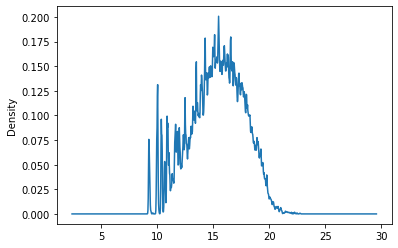

In [7]:
es1 = cb.groupby(['target_name','stage'], as_index = False).agg({"size_real": 'first'})
es2 = es1[['target_name','size_real']].groupby(['target_name'],as_index=False).sum()
es3 = es2[es2['size_real']!=0]
np.log(es3['size_real']).plot.kde(0.01)

<AxesSubplot:ylabel='Density'>

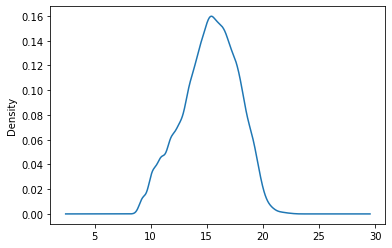

In [8]:
np.log(es3['size_real']).plot.kde()

In [10]:
es3.sort_values("size_real",ascending=False)[0:300]

In [11]:
cb[cb['target_name']=='zumutor']

target_name            stage  size_MLN        date     investors_name  \
4161       zumutor  Other Investors       NaN         NaN  Chiratae Ventures   
151846     zumutor         Series A       4.0  11/27/2019              Accel   
151847     zumutor         Series A       4.0  11/27/2019        Bharat Fund   

                url                                        description  \
4161    zumutor.com  Zumutor is an immuno-oncology company that dev...   
151846  zumutor.com  Zumutor is an immuno-oncology company that dev...   
151847  zumutor.com  Zumutor is an immuno-oncology company that dev...   

             industry target_country  \
4161    Biotechnology  United States   
151846  Biotechnology  United States   
151847  Biotechnology  United States   

                                       target_collections   target_status  \
4161    Regenerative Medicine, Biopharmaceuticals and ...  Alive / Active   
151846  Regenerative Medicine, Biopharmaceuticals and ...  Alive / Active   
151847  Regenerative Medicine, Biopharmaceuticals and ...  Alive / Active   

        target_ID  target_founded       round_simp target_continent  \
4161       348607          2013.0  Other Investors    North America   
151846     348607          2013.0         Series A    North America   
151847     348607          2013.0         Series A    North America   

         target_state target_city                     target_street  \
4161    Massachusetts   Cambridge  CIC Cambridge Campus 1 Broadway…   
151846  Massachusetts   Cambridge  CIC Cambridge Campus 1 Broadway…   
151847  Massachusetts   Cambridge  CIC Cambridge Campus 1 Broadway…   

                                            target_people target_competitors  \
4161    Kavitha Rodrigues (CEO),Anirban Bhattacharya (...                NaN   
151846  Kavitha Rodrigues (CEO),Anirban Bhattacharya (...                NaN   
151847  Kavitha Rodrigues (CEO),Anirban Bhattacharya (...                NaN   

            investor_name  investor_url  \
4161    Chiratae Ventures  chiratae.com   
151846              Accel     accel.com   
151847        Bharat Fund   bharat.fund   

                                     investor_description investor_country  \
4161    Chiratae Ventures, formerly IDG Ventures India...            India   
151846  Accel is a venture capital firm that invests i...    United States   
151847  Bharat Fund is an early stage venture fund wit...            India   

          investor_type  investor_deals_now  investor_companies  \
4161    Venture Capital                44.0                19.0   
151846  Venture Capital               115.0                58.0   
151847  Venture Capital                 1.0                 1.0   

       investor_deals_total  investor_exit_12  \
4161                    256               3.0   
151846                2,061              33.0   
151847                   10               0.0   

                                             investor_ppl  investor_deals_12  \
4161    T. Meenakshisundaram (CFO),Manik Arora (Managi...               51.0   
151846                                                NaN              176.0   
151847                                                NaN                4.0   

                                     investor_collections  investor_id  \
4161          Pharma Startups, Fitness Tech and Untitled…       1572.0   
151846  Identity Management, Direct-To-Consumer Brands...        203.0   
151847                                                NaN     100506.0   

               investor_industry investor_state investor_continent  \
4161                         NaN            NaN               Asia   
151846  Investment Firms & Funds     California      North America   
151847                       NaN            NaN               Asia   

       investor_city  investor_founded  \
4161       Bengaluru            2006.0   
151846     Palo Alto            1983.0   
151847     Ahmedabad               NaN   

        

In [12]:
cb

target_name     stage  size_MLN  \
0                                       Shionogi & Co.       IPO       NaN   
1                                      Astellas Pharma       IPO       NaN   
2                            Sumitomo Dainippon Pharma       IPO       NaN   
3                                       Konica Minolta       IPO       NaN   
4                                Takeda Pharmaceutical       IPO       NaN   
...                                                ...       ...       ...   
187799                                  Beijing Shouyi  Acquired       NaN   
187800                                    Centaur Labs  Series A     15.89   
187801                     Streamline Health Solutions       IPO       NaN   
187802                                         Avelead  Acquired       NaN   
187803  Dermatology Associates and Skin Surgery Center  Acquired       NaN   

              date               investors_name                   url  \
0       05/16/1949                       Public          shionogi.com   
1       05/16/1949                       Public          astellas.com   
2       05/16/1949                       Public         ds-pharma.com   
3       05/16/1949                       Public     konicaminolta.com   
4       05/16/1949                       Public            takeda.com   
...            ...                          ...                   ...   
187799  08/17/2021                      Healgen   shouyi-biochem.com…   
187800  08/17/2021        Undisclosed Investors       centaurlabs.com   
187801  08/17/2021                       Public  streamlinehealth.net   
187802  08/17/2021  Streamline Health Solutions           avelead.com   
187803  08/17/2021         Pinnacle Dermatology            dascwv.com   

                                              description  \
0       Shionogi & Co. (TYO: 4507) focuses on the rese...   
1       Astellas Pharma (TSE: 4503) specializes in the...   
2       Sumitomo Dainippon Pharma (TYO: 4506) is a pha...   
3       Konica Minolta (コニカミノルタ) (TYO: 4902), founded ...   
4       Takeda Pharmaceutical (TYO: 4502) (NYSE: TAK) ...   
...                                                   ...   
187799  Beijing Shouyi is a biomedical enterprise, whi...   
187800  Centaur Labs enables customers to build AI alg...   
187801  Streamline Health (NASDAQ: STRM) provides solu...   
187802  Avelead provides a cloud-based platform for ho...   
187803  Dermatology Associates and Skin Surgery Center...   

                             industry target_country  \
0             Pharmaceuticals / Drugs          Japan   
1             Pharmaceuticals / Drugs          Japan   
2             Pharmaceuticals / Drugs          Japan   
3         Medical Devices & Equipment          Japan   
4             Pharmaceuticals / Drugs          Japan   
...                               ...            ...   
187799    Medical Devices & Equipment          China   
187800   Internet Software & Services  United States   
187801            Healthcare Software  United States   
187802   Internet Software & Services  United States   
187803  Medical Facilities & Services  United States   

                                       target_collections      target_status  \
0                                         Pharma Startups  IPO / Went public   
1       Digital Therapeutics, Pharma Startups, Cancer ...  IPO / Went public   
2               Digital Therapeutics and Pharma Startups…  IPO / Went public   
3                                   Conference Exhibitors  IPO / Went public   
4       Poop Tech, Pharma Startups, Rare Diseases, Sle...  IPO / Went public   
...                                                   ...                ...   
187799                                                NaN           Acquired   
187800  Digital Health, Artificial Intelligence ( AI )...     Alive / Active   
187801                                                NaN  IPO / Went public   
187802  Digital Health,

In [323]:
# cb[cb['investors_name']=='Public'][-300:]

In [14]:
#ordinare gli investitori

inv_list = list(cb['investors_name'].values)
inv_counter = {}
for inv in inv_list:
    if inv in inv_counter:
        inv_counter[inv] += 1
    else:
        inv_counter[inv] = 1

popular_invs = sorted(inv_counter, key = inv_counter.get, reverse = True)
 
top = popular_invs[:20]

In [15]:
for i in popular_invs:
    if pd.isna(i):
        print(i)

nan


In [16]:
inv_counter['Dead']

353

# GRAPHS

In [324]:
nodes_org = cb[['target_name', 'target_ID']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb[['investors_name', 'investor_id']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry","investor_id":'index' })
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index
nodes

node     index  bipartite  \
0                                         Shionogi & Co.  262824.0          1   
1                                        Astellas Pharma  243168.0          1   
2                              Sumitomo Dainippon Pharma  447180.0          1   
3                                         Konica Minolta   57191.0          1   
4                                  Takeda Pharmaceutical  373007.0          1   
...                                                  ...       ...        ...   
83253  Shenzhen Qianhai Beizeng Asset Management Co. ...  179782.0          0   
83254                  Wuxi High-Tech District Seed Fund  189318.0          0   
83255                                    Edvantage Group  190377.0          0   
83256                                            Healgen       NaN          0   
83257                        Streamline Health Solutions  152741.0          0   

          id  
0          0  
1          1  
2          2  
3          3  
4          4  
...      ...  
83253  83253  
83254  83254  
83255  83255  
83256  83256  
83257  83257  

[83258 rows x 4 columns]

In [325]:
numbers = cb.groupby(['target_name','stage'], as_index = False).count()[['target_name','stage','investors_name']].rename(columns={"investors_name": "investor_numbers"})

In [326]:
cb_new = pd.merge(cb, numbers,  how='left', left_on=['target_name','stage'], right_on = ['target_name','stage'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 1],  how='left', left_on=['target_name','target_ID'], right_on = ['node','index'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 0],  how='left', left_on=['investors_name','investor_id'], right_on = ['node','index'])


In [327]:
##ripeto quanto fatto prima (semplificato prima per risparmiare tempo) ma aggiungo roba
nodes_org = cb_new[['target_name', 'target_ID', 'target_country', 'target_continent',
               'industry','target_founded','target_status']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb_new[['investors_name', 'investor_id', 'investor_country', 'investor_continent', 'investor_type',
                   'investor_founded']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index", "target_founded":"foundation"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry", "investor_id":'index',
                                     "investor_founded":"foundation"})
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index
nodes.columns



Index(['node', 'index', 'country', 'continent', 'industry', 'foundation',
       'target_status', 'bipartite', 'id'],
      dtype='object')

In [328]:
nodes

node     index  \
0                                         Shionogi & Co.  262824.0   
1                                        Astellas Pharma  243168.0   
2                              Sumitomo Dainippon Pharma  447180.0   
3                                         Konica Minolta   57191.0   
4                                  Takeda Pharmaceutical  373007.0   
...                                                  ...       ...   
83253  Shenzhen Qianhai Beizeng Asset Management Co. ...  179782.0   
83254                  Wuxi High-Tech District Seed Fund  189318.0   
83255                                    Edvantage Group  190377.0   
83256                                            Healgen       NaN   
83257                        Streamline Health Solutions  152741.0   

             country      continent                     industry  foundation  \
0              Japan           Asia      Pharmaceuticals / Drugs      1878.0   
1              Japan           Asia      Pharmaceuticals / Drugs      1923.0   
2              Japan           Asia      Pharmaceuticals / Drugs      1897.0   
3              Japan           Asia  Medical Devices & Equipment      1936.0   
4              Japan           Asia      Pharmaceuticals / Drugs      1781.0   
...              ...            ...                          ...         ...   
83253          China           Asia              Venture Capital      2016.0   
83254          China           Asia                        Other         NaN   
83255          China           Asia                  Corporation      2015.0   
83256            NaN            NaN                          NaN         NaN   
83257  United States  North America                  Corporation         NaN   

           target_status  bipartite     id  
0      IPO / Went public          1      0  
1      IPO / Went public          1      1  
2      IPO / Went public          1      2  
3      IPO / Went public          1      3  
4      IPO / Went public          1      4  
...                  ...        ...    ...  
83253                NaN          0  83253  
83254                NaN          0  83254  
83255                NaN          0  83255  
83256                NaN          0  83256  
83257                NaN          0  83257  

[83258 rows x 9 columns]

In [22]:
B = nx.MultiGraph(name='org-bid')
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(nodes[nodes.bipartite==0].id)
B.add_nodes_from(nodes[nodes.bipartite==1].id)
nx.set_node_attributes(B, pd.Series(nodes.node, index=nodes.id).to_dict(), 'name')
nx.set_node_attributes(B, pd.Series(nodes.country, index=nodes.id).to_dict(), 'country')
nx.set_node_attributes(B, pd.Series(nodes.continent, index=nodes.continent).to_dict(), 'continent')
nx.set_node_attributes(B, pd.Series(nodes.industry, index=nodes.id).to_dict(), 'industry')
nx.set_node_attributes(B, pd.Series(nodes.foundation, index=nodes.id).to_dict(), 'foundation')
nx.set_node_attributes(B, pd.Series(nodes.bipartite, index=nodes.id).to_dict(), 'bipartite')
nx.set_node_attributes(B, pd.Series(nodes.target_status, index=nodes.id).to_dict(), 'target_status')
# Add edges only between nodes of opposite node sets
for i in range(len(cb_new)):
    B.add_edge(cb_new.loc[i,'id_y'], cb_new.loc[i,'id_x'], date=(cb_new.loc[i,'date_y']).year, m_raised=cb_new.loc[i,'size_real'], 
               investors = cb_new.loc[i,'investor_numbers'], round_simp =cb_new.loc[i,'round_simp'])

In [ ]:
##nodi brutti
#'Undisclosed Investors',
# 'Public',
#'Undisclosed Angel Investors',
#'Undisclosed Venture Investors',
#Dead


In [23]:
brutti = [x for x,y in B.nodes(data=True) if (y['name']=='Undisclosed Investors') or (y['name']=='Dead')   or (y['name']=='Public')  
          or  (y['name']=='Undisclosed Angel Investors') or (y['name']=='Undisclosed Venture Investors')]
B.remove_nodes_from(brutti)

In [ ]:
'Grant - XIII'

In [24]:
biz = [(x,y) for x,y,d in B.edges(data=True) if (d['round_simp']=='Portfolio Merger')]
biz

[(53555, 18400),
 (53882, 13658),
 (54420, 11461),
 (54420, 12507),
 (58370, 7975),
 (59311, 19853),
 (59311, 19910),
 (60228, 13572),
 (62332, 19486),
 (62332, 18609)]

In [ ]:
##degree sorting
sorted(B.degree, key=lambda x: x[1], reverse=True)

In [25]:
B.nodes[1119]

{'name': 'Bioenvision',
 'country': 'United States',
 'industry': 'Biotechnology',
 'foundation': 1996.0,
 'bipartite': 1,
 'target_status': 'Acquired'}

In [26]:
bid_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
org_nodes = set(B) - bid_nodes

# NEW GRAPHS

# FOLLOWERS

In [27]:
#DA SISTEMARE

G_bidder_follow=nx.MultiDiGraph()
for org in Pallottola.Organisation.unique():
    ord_list = list(Pallottola[Pallottola.Organisation==org].sort_values(by=['Date']).id_y)
    time_list= list(Pallottola[Pallottola.Organisation==org].sort_values(by=['Date']).Date.dt.year)
    for idx in range(len(ord_list)):
        if ord_list[idx]!= np.nan:
            for seq in range(idx, len(ord_list)):
                if ord_list[seq]!=np.nan:
                    G_bidder_follow.add_edge(ord_list[idx], ord_list[seq], year=time_list[seq])

NameError: name 'Pallottola' is not defined

# BIDBID

In [28]:
id_round = cb_new[['target_ID','round_simp']]
id_round = id_round.drop_duplicates()
id_round.index = range(len(id_round))
id_round['id_round'] = id_round.index
id_round

id_year = cb_new[['target_ID','date_y']]
id_year = id_year.drop_duplicates()
id_year.index = range(len(id_year))
id_year['id_year'] = id_year.index
id_year

target_ID date_y  id_year
0         262824   1949        0
1         243168   1949        1
2         447180   1949        2
3          57191   1949        3
4         373007   1949        4
...          ...    ...      ...
94835     669346   2021    94835
94836     377820   2021    94836
94837     439295   2021    94837
94838     439775   2021    94838
94839     669451   2021    94839

[94840 rows x 3 columns]

In [29]:
cb_new = pd.merge(cb_new, id_round,  how='left', left_on=['target_ID','round_simp'], right_on = ['target_ID','round_simp'])


In [30]:
cb_new = pd.merge(cb_new, id_year,  how='left', left_on=['target_ID','date_y'], right_on = ['target_ID','date_y'])

In [31]:
nodes_inv = nodes[nodes['bipartite']==0]

In [32]:
nodes_inv

node     index  \
50462                                             Public       NaN   
50463                                  Greylock Partners     721.0   
50464                        Undisclosed Angel Investors       NaN   
50465                                       J.H. Whitney    7440.0   
50466                                    Takeda Ventures   22591.0   
...                                                  ...       ...   
83253  Shenzhen Qianhai Beizeng Asset Management Co. ...  179782.0   
83254                  Wuxi High-Tech District Seed Fund  189318.0   
83255                                    Edvantage Group  190377.0   
83256                                            Healgen       NaN   
83257                        Streamline Health Solutions  152741.0   

             country      continent           industry  foundation  \
50462            NaN            NaN                NaN         NaN   
50463  United States  North America    Venture Capital         NaN   
50464            NaN            NaN                NaN         NaN   
50465  United States  North America     Private Equity      1946.0   
50466  United States  North America  Corporate Venture         NaN   
...              ...            ...                ...         ...   
83253          China           Asia    Venture Capital      2016.0   
83254          China           Asia              Other         NaN   
83255          China           Asia        Corporation      2015.0   
83256            NaN            NaN                NaN         NaN   
83257  United States  North America        Corporation         NaN   

      target_status  bipartite     id  
50462           NaN          0  50462  
50463           NaN          0  50463  
50464           NaN          0  50464  
50465           NaN          0  50465  
50466           NaN          0  50466  
...             ...        ...    ...  
83253           NaN          0  83253  
83254           NaN          0  83254  
83255           NaN          0  83255  
83256           NaN          0  83256  
83257           NaN          0  83257  

[32796 rows x 9 columns]

In [33]:
##bidbid in stesso anno
links = []
subcb = cb_new[['id_year','date_y','id_y']].drop_duplicates()
subcb = subcb[pd.notna(subcb['date_y'])]
for i in tqdm(subcb['id_year'].unique()):
    subcb2 = subcb[subcb['id_year']==i]
    for couple in itertools.combinations(np.unique(subcb2['id_y'].values),2):
        links.append((couple + ({'date': subcb2['date_y'].values[0].year},)))


  0%|          | 0/88171 [00:00<?, ?it/s]

In [34]:
bidbid=nx.MultiGraph()
bidbid.add_nodes_from(nodes[nodes.bipartite==0].id)
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.node, index=nodes_inv.id).to_dict(), 'name')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.country, index=nodes_inv.id).to_dict(), 'country')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.continent, index=nodes_inv.id).to_dict(), 'continent')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.industry, index=nodes_inv.id).to_dict(), 'industry')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.foundation, index=nodes_inv.id).to_dict(), 'foundation')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.bipartite, index=nodes_inv.id).to_dict(), 'bipartite')
bidbid.add_edges_from(links) 
remove = [node for node,degree in dict(bidbid.degree()).items() if degree == 0]
bidbid.remove_nodes_from(remove)
bidbid.remove_nodes_from(brutti)
nx.readwrite.write_gpickle(bidbid,'bidbid_cb.gpickle')
nx.info(bidbid)

'Name: \nType: MultiGraph\nNumber of nodes: 21902\nNumber of edges: 250433\nAverage degree:  22.8685'

In [35]:
nodes_inv.country

50462              NaN
50463    United States
50464              NaN
50465    United States
50466    United States
             ...      
83253            China
83254            China
83255            China
83256              NaN
83257    United States
Name: country, Length: 32796, dtype: object

In [36]:
bidbid.nodes[51253]

{'name': 'OrbiMed Advisors',
 'country': 'United States',
 'continent': 'North America',
 'industry': 'Venture Capital',
 'foundation': 1989.0,
 'bipartite': 0}

In [44]:
# sorted(bidbid.degree, key=lambda x: x[1], reverse=True)

In [39]:
##bidbid in stesso round
links = []
for i in cb_new['id_round'].unique():
    for couple in itertools.combinations(np.unique(cb_new[cb_new['id_round']==i]['id_y'].values),2):
            links_f.append((couple + ({'m_raised': np.unique(Pallottola[Pallottola['idx']==i]['USDraised_cpi'])),
                             'date': min(pd.to_datetime(Pallottola[Pallottola['idx']==i]['Date'].values)),
                             'round': Pallottola[Pallottola['idx']==i]['Funding type'].values[0],
                             'investors': cb_new.unique())),
                 'type': 'invinv'},)))
bidbid=MultiGraph()
bidbid.add_nodes_from(nodes.id)
bidbid.add_edges_from(links_)
    

SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' (<ipython-input-39-5069199a033a>, line 5)

In [38]:
cb_new.head()

target_name stage  size_MLN        date investors_name  \
0             Shionogi & Co.   IPO       NaN  05/16/1949         Public   
1            Astellas Pharma   IPO       NaN  05/16/1949         Public   
2  Sumitomo Dainippon Pharma   IPO       NaN  05/16/1949         Public   
3             Konica Minolta   IPO       NaN  05/16/1949         Public   
4      Takeda Pharmaceutical   IPO       NaN  05/16/1949         Public   

                 url                                        description  \
0       shionogi.com  Shionogi & Co. (TYO: 4507) focuses on the rese...   
1       astellas.com  Astellas Pharma (TSE: 4503) specializes in the...   
2      ds-pharma.com  Sumitomo Dainippon Pharma (TYO: 4506) is a pha...   
3  konicaminolta.com  Konica Minolta (コニカミノルタ) (TYO: 4902), founded ...   
4         takeda.com  Takeda Pharmaceutical (TYO: 4502) (NYSE: TAK) ...   

                      industry target_country  \
0      Pharmaceuticals / Drugs          Japan   
1      Pharmaceuticals / Drugs          Japan   
2      Pharmaceuticals / Drugs          Japan   
3  Medical Devices & Equipment          Japan   
4      Pharmaceuticals / Drugs          Japan   

                                  target_collections      target_status  \
0                                    Pharma Startups  IPO / Went public   
1  Digital Therapeutics, Pharma Startups, Cancer ...  IPO / Went public   
2          Digital Therapeutics and Pharma Startups…  IPO / Went public   
3                              Conference Exhibitors  IPO / Went public   
4  Poop Tech, Pharma Startups, Rare Diseases, Sle...  IPO / Went public   

   target_ID  target_founded round_simp target_continent target_state  \
0     262824          1878.0        IPO             Asia          NaN   
1     243168          1923.0        IPO             Asia          NaN   
2     447180          1897.0        IPO             Asia          NaN   
3      57191          1936.0        IPO             Asia          NaN   
4     373007          1781.0        IPO             Asia          NaN   

  target_city                           target_street  \
0       Osaka        1-8, Doshomachi 3-chome Chuo-ku…   
1       Tokyo      2-5-1, Nihonbashi-Honcho, Chuo-ku…   
2       Osaka        6-8, Doshomachi 2-chome Chuo-ku…   
3       Tokyo  JP Tower 2-7-2 Marunouchi, Chiyoda-ku…   
4       Tokyo      2-1-1 Nihonbashihonmachi, Chuo-ku…   

                                       target_people  \
0                                                NaN   
1  Yoshihiko Hatanaka (CEO),Yoshirou Myyokawa (EV...   
2                                  Masayo Tada (CEO)   
3                                Michael Mathé (SVP)   
4  Frank Morich (CEO),Yasuchika Hasegawa (CEO),Da...   

                                  target_competitors investor_name  \
0                          Sumitomo Dainippon Pharma           NaN   
1                          Sumitomo Dainippon Pharma           NaN   
2  Astellas Pharma,Chugai Pharmaceutical,Daiichi ...           NaN   
3                                              Xerox           NaN   
4                Sumitomo Dainippon Pharma,Sunovion…           NaN   

  investor_url investor_description investor_country investor_type  \
0          NaN                  NaN              NaN           NaN   
1          NaN                  NaN              NaN           NaN   
2          NaN                  NaN              NaN           NaN   
3          NaN                  NaN              NaN           NaN   
4          NaN                  NaN              NaN           NaN   

   investor_deals_now  investor_companies investor_deals_total  \
0                 NaN                 NaN                  NaN   
1                 NaN                 NaN                  NaN   
2                 NaN                 NaN                  NaN   
3                 NaN                 NaN                  NaN   
4                 NaN                 NaN                  NaN   

   investor

# WINDOW

In [ ]:
from itertools import islice

def window(seq, n):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [ ]:
finestra = window(list(range(2000,2022)),5)

In [ ]:
for periodo in finestra:
    locals()["B_"+str(periodo[-1])]=nx.MultiGraph([(u,v,d) for u,v,d in B.edges(data=True) if d['date'] in periodo])

# COMMUNITIES

In [ ]:
partition = community_louvain.best_partition(bidbid)

In [ ]:
partition

In [ ]:
pos = nx.spring_layout(B)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [ ]:
len(partition)

In [ ]:
cb_new.groupby('round_simp').count()

In [ ]:
'Asset Sale' 'Convertible Note' 'Dead' 'Debt' 'Distressed & Special Situation' 'Leveraged Buyout' 'Line of Credit' 'Loan'
'Mezzanine' 'Merger' 'Revenue Finance' 'Project Finance'

# Descriptive statistics

In [43]:
nodes

node     index  \
0                                         Shionogi & Co.  262824.0   
1                                        Astellas Pharma  243168.0   
2                              Sumitomo Dainippon Pharma  447180.0   
3                                         Konica Minolta   57191.0   
4                                  Takeda Pharmaceutical  373007.0   
...                                                  ...       ...   
83253  Shenzhen Qianhai Beizeng Asset Management Co. ...  179782.0   
83254                  Wuxi High-Tech District Seed Fund  189318.0   
83255                                    Edvantage Group  190377.0   
83256                                            Healgen       NaN   
83257                        Streamline Health Solutions  152741.0   

             country      continent                     industry  foundation  \
0              Japan           Asia      Pharmaceuticals / Drugs      1878.0   
1              Japan           Asia      Pharmaceuticals / Drugs      1923.0   
2              Japan           Asia      Pharmaceuticals / Drugs      1897.0   
3              Japan           Asia  Medical Devices & Equipment      1936.0   
4              Japan           Asia      Pharmaceuticals / Drugs      1781.0   
...              ...            ...                          ...         ...   
83253          China           Asia              Venture Capital      2016.0   
83254          China           Asia                        Other         NaN   
83255          China           Asia                  Corporation      2015.0   
83256            NaN            NaN                          NaN         NaN   
83257  United States  North America                  Corporation         NaN   

           target_status  bipartite     id  
0      IPO / Went public          1      0  
1      IPO / Went public          1      1  
2      IPO / Went public          1      2  
3      IPO / Went public          1      3  
4      IPO / Went public          1      4  
...                  ...        ...    ...  
83253                NaN          0  83253  
83254                NaN          0  83254  
83255                NaN          0  83255  
83256                NaN          0  83256  
83257                NaN          0  83257  

[83258 rows x 9 columns]

## Adding bidder specific covariates

In [ ]:
# locals()["bidbiddir"+str(periodo[-1])]

In [76]:
valori=2
valour=3
lista=[]
lista.append(valori)

In [77]:
lista

[2]

In [57]:
bidbid_multi=nx.readwrite.read_gpickle('bidbid_stage_cb.gpickle')

In [80]:
bidbid_stage_single=nx.readwrite.read_gpickle('bidbid_stage_single_cb.gpickle')

In [58]:
nx.info(bidbid_multi)

'Name: \nType: MultiGraph\nNumber of nodes: 17089\nNumber of edges: 221765\nAverage degree:  25.9541'

### 1. Connected components

In [45]:
nx.info(B)

'Name: org-bid\nType: MultiGraph\nNumber of nodes: 83253\nNumber of edges: 159161\nAverage degree:   3.8235'

In [46]:
dictionary={}
count=0
for component in nx.connected_components(B):
    dictionary[count]=(component,len(component))
    count+=1

In [48]:
for node in tqdm(range(len(nodes))):
    dictionary2={}
    for component in range(len(dictionary)):
        if node in dictionary[component][0]:
            dictionary2[component]=dictionary[component][1]
    try:
        nodes.iloc[node,8]=[dictionary2]
    except:
        nodes.iloc[node,8]=np.nan

  0%|          | 0/83258 [00:00<?, ?it/s]

In [50]:
nx.number_connected_components(B)

12785

### 2. Degree centrality

In [51]:
deg_centrality=nx.degree_centrality(B)

### 3. Constraint (structural holes)

Constraint means how tied you are/how controlloed you are (in percentage). Low percentage means that your neighbors don't talk with one another, and this leads you to have more freedom. <b> TOO SLOW </b>

In [60]:
# constraint=nx.constraint(bidbid_multi)

### 4. Voterank centrality

In [ ]:
votes=nx.voterank(B)
votes_bidders=nx.voterank(bidbid_multi)

### 5. Eigenvector centrality (bipartite)

In [63]:
# nx.eigenvector_centrality(bidbid_stage_single)

### 6. Eigenvector centrality (bid-bid) 

General eigenvector centrality of investors

In [ ]:
nx.eigenvector_centrality(B)

Eigenvector centrality of time windows (4 years time window)

In [ ]:
nx.eigenvector_centrality(B)

### 8. Pagerank centrality (bid-bid)

In [ ]:
nx.pagerank(B)

### 9. Closeness centrality

In [ ]:
nx.closeness_centrality(B)
nx.incremental_closeness_centrality(B)

### 10. Betweenness centrality

In [ ]:
nx.betweenness_centrality(B)

### 11. Load centrality

In [ ]:
nx.load_centrality(B)

### 12. Subgraph centrality

In [ ]:
nx.subgraph_centrality(G)

### 13. Dispersion

In [ ]:
nx.dispersion(B)

### 14. Percolation

In [ ]:
nx.percolation_centrality(B)

### 15. Assortativity - average neighboring degree

In [ ]:
neigh_degree=nx.average_neighbor_degree(B)

## Applying all the functions to the network

In [238]:
lista_nomi

['<function voterank at 0x7fc0292eeb80>_single_1997',
 '<function voterank at 0x7fc0292eeb80>_single_1998',
 '<function voterank at 0x7fc0292eeb80>_single_1999',
 '<function voterank at 0x7fc0292eeb80>_single_2000',
 '<function voterank at 0x7fc0292eeb80>_single_2001',
 '<function voterank at 0x7fc0292eeb80>_single_2002',
 '<function voterank at 0x7fc0292eeb80>_single_2003',
 '<function voterank at 0x7fc0292eeb80>_single_2004',
 '<function voterank at 0x7fc0292eeb80>_single_2005',
 '<function voterank at 0x7fc0292eeb80>_single_2006',
 '<function voterank at 0x7fc0292eeb80>_single_2007',
 '<function voterank at 0x7fc0292eeb80>_single_2008',
 '<function voterank at 0x7fc0292eeb80>_single_2009',
 '<function voterank at 0x7fc0292eeb80>_single_2010',
 '<function voterank at 0x7fc0292eeb80>_single_2011',
 '<function voterank at 0x7fc0292eeb80>_single_2012',
 '<function voterank at 0x7fc0292eeb80>_single_2013',
 '<function voterank at 0x7fc0292eeb80>_single_2014',
 '<function voterank at 0x7f

In [6]:
nx.readwrite.read_gpickle('orgorg3_single_/orgorg3_single1980.gpickle')

In [243]:
string

NameError: name 'string' is not defined

In [7]:
def apply_function_network(lista_storage,lista_nomi,funzione,directed=False):
    for year in tqdm(range(1999,2019)):
        string='orgorg3_single_/orgorg3_single'+str(year)+'.gpickle'
        network=nx.readwrite.read_gpickle(string)
        storage=str(funzione)+'_orgorg3_single'+str(year)
        lista_storage.append(funzione(network))
        lista_nomi.append(storage)
    #network=nx.readwrite.read_gpickle('bidbid_stage_single_cb.gpickle')
    #lista_storage.append(funzione(network))
    #lista_nomi.append(str(funzione)+'_single')
    return lista_storage,lista_nomi
def apply_function_network_community(lista_storage,lista_nomi,funzione,directed=False):
    for year in tqdm(range(1999,2020)):
        string='orgorg3_single_/orgorg3_single'+str(year)+'.gpickle'
        network=nx.readwrite.read_gpickle(string)
        storage='Louvain_orgorg3_single'+str(year)
        lista_storage.append(funzione(network))
        lista_nomi.append(storage)
    #network=nx.readwrite.read_gpickle('bidbid_stage_single_cb.gpickle')
    #lista_storage.append(funzione(network))
    #lista_nomi.append(str(funzione)+'_single')
    return lista_storage,lista_nomi

In [50]:
network=nx.readwrite.read_gpickle('orgorg3_single_/orgorg3_single'+str(2001)+'.gpickle')


In [20]:
len(sorted(nx.connected_components(network), key=len, reverse=True)[0])

27901

In [51]:
connected = sorted(nx.connected_components(network),key = len, reverse = True)[0]

In [52]:
connected2 = network.subgraph(connected).copy()

In [53]:
connected2.number_of_nodes()

2286

In [67]:
network.nodes

NodeView((7945, 7200, 6948, 7474, 6967, 6712, 7228, 6725, 7371, 6757, 7530, 7160, 8204, 7196, 7226, 7753, 6769, 7813, 6795, 6805, 7326, 7354, 6847, 6864, 9450, 7446, 6962, 9041, 7002, 7548, 7060, 7080, 7095, 7119, 7143, 7555, 8427, 7599, 8337, 1625, 9105, 7581, 8479, 6707, 7347, 7093, 7100, 6854, 6732, 6738, 6872, 6747, 8546, 7152, 6901, 8574, 9749, 9240, 6682, 9757, 2591, 8241, 6711, 7252, 1631, 6754, 7790, 8306, 6793, 1164, 8332, 7316, 7834, 7889, 7891, 8918, 7897, 8926, 7402, 8433, 9001, 6960, 6988, 6992, 8528, 6994, 2389, 9054, 9058, 7547, 7049, 7053, 2457, 9718, 8186, 8190, 6788, 6789, 7052, 6935, 6819, 6826, 6713, 6971, 6716, 6720, 6978, 6724, 6984, 6858, 6991, 7256, 7009, 6765, 7277, 7285, 6907, 6791, 6924, 7062, 7064, 6939, 7068, 6945, 6776, 7344, 6969, 6843, 6849, 6723, 6997, 7003, 7262, 7265, 7272, 6904, 7019, 7149, 6958, 7024, 7560, 8980, 6549, 7869, 6782, 6860, 7895, 7273, 6766, 7422, 8192, 9242, 8821, 8889, 2252, 9451, 8056, 7545, 9096, 1530, 1053, 7606, 6623, 7657, 5237, 

In [70]:
u = 7945
v = 1625

In [ ]:
nx.subgraph_centrality, nx.average_neighbor_degree

In [ ]:
#nx.dispersion
#nx.constraint
#nx.betweenness_centrality
#nx.percolation_centrality
#nx.trophic_levels
#nx.harmonic_centrality
#nx.enumerate_all_cliques,
#nx.clustering
#nx.core_number
#nx.rich_club_coefficient
#nx.closeness_vitality
#nx.voterank
#nx.eigenvector_centrality
#nx.degree_centrality
#nx.pagerank
#nx.closeness_centrality
#nx.incremental_closeness_centrality
#nx.load_centrality
#nx.subgraph_centrality
#nx.average_neighbor_degree

In [90]:
a = nx.load_centrality(network)

In [129]:
b =nx.subgraph_centrality(network)

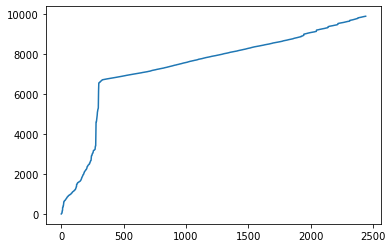

In [135]:
plt.plot(pd.Series(sorted(b)))

In [106]:
[c for c in a.values]# - b.values

TypeError: 'builtin_function_or_method' object is not iterable

In [126]:
min(sorted(pd.Series(list((a.values())))/pd.Series(list(b.values())), reverse = False))


0.8374792534540265

ZeroDivisionError: division by zero

In [74]:
nx.local_constraint(network, u, v)

0.0007536191800536249

In [49]:
sorted(possib)

[(6624, 10234),
 (6624, 11834),
 (6624, 12750),
 (6624, 16355),
 (6624, 16719),
 (6624, 16874),
 (6624, 18765),
 (6624, 19344),
 (6624, 20425),
 (6624, 28258),
 (6624, 33748),
 (6624, 45002),
 (11834, 10234),
 (11834, 33748),
 (12750, 10234),
 (12750, 11834),
 (12750, 16719),
 (12750, 19344),
 (12750, 33748),
 (16355, 10234),
 (16355, 11834),
 (16355, 12750),
 (16355, 16719),
 (16355, 16874),
 (16355, 18765),
 (16355, 19344),
 (16355, 20425),
 (16355, 33748),
 (16355, 45002),
 (16719, 10234),
 (16719, 11834),
 (16719, 19344),
 (16719, 33748),
 (16874, 10234),
 (16874, 11834),
 (16874, 12750),
 (16874, 16719),
 (16874, 18765),
 (16874, 19344),
 (16874, 33748),
 (16874, 45002),
 (18765, 10234),
 (18765, 11834),
 (18765, 12750),
 (18765, 16719),
 (18765, 19344),
 (18765, 33748),
 (19344, 10234),
 (19344, 11834),
 (19344, 33748),
 (20425, 10234),
 (20425, 11834),
 (20425, 12750),
 (20425, 16719),
 (20425, 16874),
 (20425, 18765),
 (20425, 19344),
 (20425, 33748),
 (20425, 45002),
 (28258, 

In [43]:
sorted(network.neighbors(45000))

[6624,
 8703,
 10234,
 11834,
 12750,
 16355,
 16719,
 16874,
 18765,
 19344,
 20425,
 28258,
 33748,
 45002]

In [31]:
#nx.percolation_centrality(connected2)
nx.dispersion(network)

KeyboardInterrupt: 

In [384]:
# Array di funzioni da applicare - ciclo for su di esse
#lista_funzioni=[nx.voterank, nx.eigenvector_centrality, nx.degree_centrality, nx.pagerank, nx.closeness_centrality, nx.incremental_closeness_centrality, nx.load_centrality, nx.subgraph_centrality, nx.dispersion, nx.percolation_centrality,nx.average_neighbor_degree,nx.constraint, nx.betweenness_centrality]
lista_funzioni2=[nx.dispersion,nx.constraint,nx.betweenness_centrality, nx.trophic_levels, nx.harmonic_centrality, nx.enumerate_all_cliques, nx.clustering, nx.core_number, nx.rich_club_coefficient, nx.closeness_vitality]
lista_funzioni_rifare=[nx.harmonic_centrality, nx.enumerate_all_cliques, nx.clustering,nx.core_number,nx.closeness_vitality]
# Funzione prende df, se direzionato o meno
lista_funzioni_prova2=[nx.eigenvector_centrality, nx.degree]
lista_storage2=[]
lista_nomi2=[]
for funzione in lista_funzioni_rifare:
    try:
        print('Trying'+str(funzione))
        lista_storage2, lista_nomi2=apply_function_network(lista_storage2,lista_nomi2,funzione)
    except:
        print(str(funzione)+' did not work')
        continue

Trying<function harmonic_centrality at 0x7fc0292d8b80>


  0%|          | 0/20 [00:00<?, ?it/s]

Trying<function enumerate_all_cliques at 0x7fc029318430>


  0%|          | 0/20 [00:00<?, ?it/s]

Trying<function clustering at 0x7fc029310d30>


  0%|          | 0/20 [00:00<?, ?it/s]

Trying<function core_number at 0x7fc029331670>


  0%|          | 0/20 [00:00<?, ?it/s]

Trying<function closeness_vitality at 0x7fbff94c9940>


  0%|          | 0/20 [00:00<?, ?it/s]

<function closeness_vitality at 0x7fbff94c9940> did not work


Adding the column names to the dataframe

In [261]:
test_str

'<function betweenness_centrality at 0x7fc0292c1f70>_orgorg3_single1999'

In [693]:
import re

regex = r"(?<=function )(.*)(?= at)"
regex2= r"\>(.*)"

for test_str in lista_nomi2:
    matches = re.finditer(regex, test_str, re.MULTILINE)
    matches2 = re.finditer(regex2, test_str, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):
        stringa1=match.group()
    for matchNum, match in enumerate(matches2, start=1):
        stringa2=match.group()
    stringa_totale=stringa1+stringa2[1:]
    nodes[stringa_totale]=np.nan
nodes

node     index  \
0                                         Shionogi & Co.  262824.0   
1                                        Astellas Pharma  243168.0   
2                              Sumitomo Dainippon Pharma  447180.0   
3                                         Konica Minolta   57191.0   
4                                  Takeda Pharmaceutical  373007.0   
...                                                  ...       ...   
83253  Shenzhen Qianhai Beizeng Asset Management Co. ...  179782.0   
83254                  Wuxi High-Tech District Seed Fund  189318.0   
83255                                    Edvantage Group  190377.0   
83256                                            Healgen       NaN   
83257                        Streamline Health Solutions  152741.0   

             country      continent                     industry  foundation  \
0              Japan           Asia      Pharmaceuticals / Drugs      1878.0   
1              Japan           Asia      Pharmaceuticals / Drugs      1923.0   
2              Japan           Asia      Pharmaceuticals / Drugs      1897.0   
3              Japan           Asia  Medical Devices & Equipment      1936.0   
4              Japan           Asia      Pharmaceuticals / Drugs      1781.0   
...              ...            ...                          ...         ...   
83253          China           Asia              Venture Capital      2016.0   
83254          China           Asia                        Other         NaN   
83255          China           Asia                  Corporation      2015.0   
83256            NaN            NaN                          NaN         NaN   
83257  United States  North America                  Corporation         NaN   

           target_status  bipartite     id  voterank_orgorg3_single1999  \
0      IPO / Went public          1      0                          NaN   
1      IPO / Went public          1      1                          NaN   
2      IPO / Went public          1      2                          NaN   
3      IPO / Went public          1      3                          NaN   
4      IPO / Went public          1      4                          NaN   
...                  ...        ...    ...                          ...   
83253                NaN          0  83253                          NaN   
83254                NaN          0  83254                          NaN   
83255                NaN          0  83255                          NaN   
83256                NaN          0  83256                          NaN   
83257                NaN          0  83257                          NaN   

       voterank_orgorg3_single2000  voterank_orgorg3_single2001  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   
...                            ...                          ...   
83253                          NaN                          NaN   
83254                          NaN                          NaN   
83255                          NaN                          NaN   
83256                          NaN                          NaN   
83257                          NaN                          NaN   

       voterank_orgorg3_single2002  voterank_orgorg3_single2003  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   
...                            ...                          ...   
83253                          NaN                          NaN   
83254   

In [698]:
nodes.columns[191]

'harmonic_centrality_orgorg3_single1999'

In [330]:
#Inserisco voterank
# for voterank_year in tqdm(range(18)):
#     for rank in range(len(lista_storage[voterank_year])):
#         nodes.iloc[lista_storage[voterank_year][rank],9+voterank_year]=rank
#Inserisco le altre covariate fino a dispersion

for covariate in tqdm(range(136,161)):
    for node in lista_storage[covariate]:
        nodes.iloc[node,9+covariate]=lista_storage[covariate][node]

  0%|          | 0/18 [00:00<?, ?it/s]

In [307]:
# lista_storage[136]

In [234]:
nodes.iloc[50465,9+174]=[lista_storage[174][0][50465]]

In [331]:
#Inserisco le altre covariate, compresa dispersion
for covariate in tqdm(range(18,171)):
    for node in lista_storage[covariate]:
        try:
            nodes.iloc[node,9+covariate]=lista_storage[covariate][node]
        except:
            nodes.iloc[node,9+covariate]=[lista_storage[covariate][node]]

  0%|          | 0/153 [00:00<?, ?it/s]

IndexError: list index out of range

In [337]:
nodes.columns[160]

'average_neighbor_degree_orgorg3_single2010'

In [338]:
nodes.to_csv('~/Documents/GitHub/crunch_net/notebook/CB_with_covariates_companies.csv')

In [342]:
nx.info(B)

'Name: org-bid\nType: MultiGraph\nNumber of nodes: 83253\nNumber of edges: 159161\nAverage degree:   3.8235'

## Community discovery

In [350]:
from cdlib import algorithms
import networkx as nx
coms = algorithms.louvain(B, weight=weight’, resolution=1., randomize=False)

In [556]:
# Array di funzioni da applicare - ciclo for su di esse
#lista_funzioni2=[nx.dispersion,nx.constraint,nx.betweenness_centrality, nx.trophic_levels, nx.harmonic_centrality, nx.enumerate_all_cliques, nx.clustering, nx.core_number, nx.rich_club_coefficient, nx.closeness_vitality]
# Funzione prende df, se direzionato o meno
lista_community=[]
lista_nomi_community=[]
lista_community, lista_nomi_community=apply_function_network_community(lista_community,lista_nomi_community,algorithms.louvain)


  0%|          | 0/21 [00:00<?, ?it/s]

In [368]:
len(lista_community[0].communities)
lista_nomi_community[0]

'Louvain_orgorg3_single1999'

In [557]:
for indice in range(len(lista_nomi_community)):
    nodes[lista_nomi_community[indice]]=np.nan
    for numero in range(len(lista_community[indice].communities)):
        for nodo in lista_community[indice].communities[numero]:
            nodes.iloc[nodo,170+indice]=numero

In [559]:
#This proves to you that they are ordered by size

for i in range(len(lista_community)):
    for j in range(len(lista_community[i].communities)):
        print(len(lista_community[i].communities[j]))

In [392]:
lista_nomi_community

['Louvain_orgorg3_single1999',
 'Louvain_orgorg3_single2000',
 'Louvain_orgorg3_single2001',
 'Louvain_orgorg3_single2002',
 'Louvain_orgorg3_single2003',
 'Louvain_orgorg3_single2004',
 'Louvain_orgorg3_single2005',
 'Louvain_orgorg3_single2006',
 'Louvain_orgorg3_single2007',
 'Louvain_orgorg3_single2008',
 'Louvain_orgorg3_single2009',
 'Louvain_orgorg3_single2010',
 'Louvain_orgorg3_single2011',
 'Louvain_orgorg3_single2012',
 'Louvain_orgorg3_single2013',
 'Louvain_orgorg3_single2014',
 'Louvain_orgorg3_single2015',
 'Louvain_orgorg3_single2016',
 'Louvain_orgorg3_single2017',
 'Louvain_orgorg3_single2018']

In [411]:
#Create names for variables
def create_names_in_year_range(year1,year2):
    names_1=[]
    names_2=[]
    names_3=[]
    for year in range(year1,year2):
        names_1.append('first_community_'+str(year))
        names_2.append('second_community_'+str(year))
        names_3.append('third_community_'+str(year))
    return names_1,names_2,names_3
#get the metric
def get_intersection_value(community1,community2):
    length=len(set(community1).intersection(set(community2)))
    ratio=length/len(community1)
    return ratio
    
#Assign to named variables
names_1,names_2,names_3=create_names_in_year_range(1999,2019)
for i in range(0,20):
    locals()[names_1[i]]=lista_community[i].communities[0]
    locals()[names_2[i]]=lista_community[i].communities[1]
    locals()[names_3[i]]=lista_community[i].communities[2]

#Create the dataframe
# matrix_intersection_communities=pd.DataFrame(columns=names_1,index=names_1)
#Populate the dataframe




In [817]:
total_length=0
array_total=[]
for j in range(20):
    array_percentages_1=[]
    for year in range(len(lista_community)):
        total_length=0
        for i in range(len(lista_community[year].communities)):
            total_length+=len(lista_community[year].communities[i])
        array_percentages_1.append(len(lista_community[year].communities[j])/total_length)
    array_total.append(array_percentages_1)
round(pd.DataFrame(array_total)*100,3)

0       1       2       3       4       5       6       7       8   \
0   13.965  16.428  19.116  20.361  20.390  19.431  17.055  18.454  15.377   
1   13.386  14.381  18.502  14.152  15.946  18.244  12.279  15.717  12.096   
2    8.538  12.948  13.549  13.909  12.781  11.864  11.673  13.162  10.934   
3    8.249  12.487  13.099   7.804   8.460   8.516  11.650  11.391   9.927   
4    7.525  10.696   7.655   7.492   7.821   7.857   9.669   8.855   7.185   
5    7.525   8.854   4.380   6.209   7.730   4.693   7.665   5.876   7.098   
6    7.308   4.350   4.257   6.209   5.508   4.640   5.126   4.568   6.578   
7    6.802   3.275   3.889   5.238   5.143   4.297   4.450   3.361   4.061   
8    6.006   2.661   3.643   3.573   3.834   4.086   4.101   3.099   3.645   
9    4.124   1.586   2.824   1.977   2.617   3.638   3.938   2.536   3.297   
10   3.039   1.535   1.719   1.838   1.948   2.056   2.773   2.355   3.054   
11   2.533   1.228   0.409   1.318   1.430   1.846   2.260   1.509   2.985   
12   1.809   0.563   0.368   0.832   0.274   1.766   0.839   0.926   1.614   
13   0.868   0.461   0.327   0.520   0.243   0.211   0.303   0.885   1.510   
14   0.434   0.409   0.246   0.451   0.213   0.158   0.140   0.362   1.458   
15   0.434   0.358   0.246   0.382   0.183   0.158   0.140   0.302   0.920   
16   0.434   0.307   0.205   0.347   0.183   0.158   0.140   0.241   0.260   
17   0.362   0.307   0.164   0.277   0.152   0.158   0.140   0.201   0.260   
18   0.362   0.307   0.123   0.243   0.152   0.158   0.116   0.181   0.260   
19   0.289   0.307   0.123   0.243   0.152   0.158   0.116   0.141   0.226   

        9       10      11      12      13      14      15      16      17  \
0   20.725  11.468  18.578  15.512  13.080  14.261  13.180  10.948  10.816   
1   13.126  11.093  13.433  13.269  10.127  10.812  12.116  10.583  10.141   
2   12.834   9.716  10.015  10.557   9.381   7.692   9.754   9.781   8.499   
3    7.706   9.286   7.023   8.169   7.546   6.854   8.090   8.275   7.851   
4    5.757   8.632   6.760   7.823   7.487   6.655   6.568   6.826   6.918   
5    4.421   8.479   6.422   6.249   6.722   6.508   6.118   6.314   6.890   
6    4.160   7.770   5.095   5.814   6.172   6.422   4.318   4.859   5.089   
7    3.976   7.075   4.244   5.089   5.269   6.344   4.221   4.615   4.980   
8    3.592   4.810   4.094   4.464   4.946   5.471   4.191   4.442   3.799   
9    3.285   3.809   3.242   2.645   3.964   3.639   3.569   2.493   3.668   
10   3.255   3.517   2.829   2.522   3.395   3.008   3.464   2.231   3.305   
11   2.994   2.850   2.729   2.299   3.111   3.008   2.497   2.192   2.432   
12   1.551   2.738   2.178   2.210   2.434   2.835   1.837   2.173   1.598   
13   1.474   0.528   1.602   1.395   2.129   2.031   1.829   2.102   1.559   
14   1.320   0.306   1.590   0.815   1.423   1.374   1.582   1.756   1.455   
15   0.768   0.292   0.876   0.759   1.187   1.253   1.342   1.737   1.384   
16   0.768   0.250   0.275   0.591   1.070   1.175   1.237   1.474   1.362   
17   0.599   0.195   0.213   0.357   0.864   0.519   1.050   1.231   1.329   
18   0.292   0.181   0.188   0.223   0.746   0.475   0.742   1.147   1.235   
19   0.246   0.139   0.175   0.190   0.167   0.182   0.600   1.115   1.142   

        18      19      20  
0   11.937  14.992  15.866  
1   10.458  11.014  10.191  
2   10.233   9.421   8.300  
3    9.981   9.341   6.643  
4    9.276   5.953   6.446  
5    4.599   4.010   5.981  
6    4.346   3.918   5.092  
7    4.188   3.779   3.593  
8    4.076   3.667   3.521  
9    3.931   2.827   3.294  
10   2.171   2.732   2.956  
11   2.068   2.536   2.505  
12   1.760   2.405   2.274  
13   1.569   2.202   1.643  
14   1.190   2.150   1.626  
15   0.934   1.625   1.530  
16   0.910   1.477   1.009  
17   0.901   0.330   0.927  
18   0.518   0.279   0.241  
19   0.285   0.183   0.179

In [813]:
total_length=0
for i in range(len(lista_community[10].communities)):
    total_length+=len(lista_community[10].communities[i])
len(lista_community[10].communities[0])/total_length

0.11467889908256881

In [412]:
names_matrix=[]
for year in range(1999,2019):
    names_matrix.append(str(year))
matrix_intersection_communities=pd.DataFrame(columns=names_matrix,index=names_matrix)

In [413]:
matrix_intersection_communities

1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012  \
1999  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2001  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2002  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2003  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2004  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2005  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2006  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2007  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2008  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2009  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2010  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2011  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2012  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2013  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2014  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2015  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2016  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2017  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2018  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

     2013 2014 2015 2016 2017 2018  
1999  NaN  NaN  NaN  NaN  NaN  NaN  
2000  NaN  NaN  NaN  NaN  NaN  NaN  
2001  NaN  NaN  NaN  NaN  NaN  NaN  
2002  NaN  NaN  NaN  NaN  NaN  NaN  
2003  NaN  NaN  NaN  NaN  NaN  NaN  
2004  NaN  NaN  NaN  NaN  NaN  NaN  
2005  NaN  NaN  NaN  NaN  NaN  NaN  
2006  NaN  NaN  NaN  NaN  NaN  NaN  
2007  NaN  NaN  NaN  NaN  NaN  NaN  
2008  NaN  NaN  NaN  NaN  NaN  NaN  
2009  NaN  NaN  NaN  NaN  NaN  NaN  
2010  NaN  NaN  NaN  NaN  NaN  NaN  
2011  NaN  NaN  NaN  NaN  NaN  NaN  
2012  NaN  NaN  NaN  NaN  NaN  NaN  
2013  NaN  NaN  NaN  NaN  NaN  NaN  
2014  NaN  NaN  NaN  NaN  NaN  NaN  
2015  NaN  NaN  NaN  NaN  NaN  NaN  
2016  NaN  NaN  NaN  NaN  NaN  NaN  
2017  NaN  NaN  NaN  NaN  NaN  NaN  
2018  NaN  NaN  NaN  NaN  NaN  NaN

In [488]:
for i in range(0,20):
    for j in range(0,20):
        matrix_intersection_communities.iloc[i,j]=round(get_intersection_value(locals()[names_2[i]],locals()[names_1[j]]),2)

In [482]:
matrix_intersection_communities

1999  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  \
1999   1.0   0.2  0.33  0.31  0.05  0.04  0.05  0.01  0.26  0.01  0.01  0.04   
2000  0.11   1.0  0.69  0.69  0.07  0.06  0.04   0.0  0.15   0.0   0.0   0.0   
2001  0.11  0.41   1.0  0.57  0.04  0.04  0.03   0.0   0.1   0.0   0.0  0.01   
2002  0.11  0.44   0.6   1.0  0.02  0.03  0.02   0.0  0.15   0.0   0.0  0.02   
2003  0.02  0.04  0.04  0.02   1.0  0.57  0.64  0.03  0.06  0.02  0.03  0.13   
2004  0.01  0.03  0.03  0.03  0.53   1.0  0.64  0.03  0.12  0.02  0.02  0.15   
2005  0.01  0.02  0.02  0.01  0.49  0.53   1.0  0.01  0.13  0.01  0.01  0.14   
2006   0.0   0.0   0.0   0.0  0.02  0.02  0.01   1.0   0.0  0.91   0.9  0.17   
2007  0.05  0.05  0.05  0.08  0.04  0.07   0.1   0.0   1.0  0.01  0.01  0.05   
2008   0.0   0.0   0.0   0.0  0.01  0.01  0.01  0.75  0.01   1.0  0.93  0.24   
2009   0.0   0.0   0.0   0.0  0.01  0.01  0.01  0.69  0.01  0.87   1.0  0.25   
2010  0.01   0.0  0.01  0.01  0.07  0.09   0.1  0.13  0.05  0.23  0.26   1.0   
2011  0.06  0.19  0.38  0.27  0.03  0.02  0.03   0.0   0.1   0.0   0.0  0.01   
2012   0.0   0.0   0.0   0.0  0.01  0.01  0.01  0.47  0.01  0.58  0.61  0.25   
2013   0.0   0.0  0.01   0.0  0.03  0.03  0.02   0.4  0.01  0.48  0.51  0.28   
2014  0.01   0.0  0.01  0.01  0.15   0.2  0.22  0.01  0.04  0.01  0.02  0.15   
2015  0.01  0.02  0.04  0.03   0.1  0.15  0.16  0.08  0.11   0.1   0.1  0.09   
2016   0.0   0.0   0.0   0.0  0.01   0.0  0.01  0.07  0.01  0.09  0.09  0.17   
2017   0.0   0.0   0.0   0.0  0.01  0.01  0.01  0.06  0.01  0.08  0.09  0.17   
2018  0.01  0.01  0.01  0.03  0.01  0.01  0.01   0.0  0.07  0.01  0.01  0.01   

      2011  2012  2013  2014  2015  2016  2017  2018  
1999  0.37  0.01  0.01  0.05  0.16  0.01   0.0  0.09  
2000  0.64   0.0  0.01  0.02  0.12  0.01   0.0  0.12  
2001  0.77   0.0  0.02  0.04  0.18  0.01   0.0  0.03  
2002  0.59   0.0   0.0  0.03  0.15  0.01   0.0   0.2  
2003  0.05  0.03  0.08  0.46  0.43  0.03  0.05  0.05  
2004  0.03  0.03  0.07  0.53  0.57  0.02  0.05  0.03  
2005  0.04  0.02  0.05  0.49  0.53  0.02  0.03  0.02  
2006   0.0  0.89  0.86  0.02  0.24  0.23  0.23  0.01  
2007  0.11  0.01  0.01  0.06  0.25  0.01  0.02   0.2  
2008   0.0  0.92  0.86  0.02  0.24  0.26  0.25  0.02  
2009   0.0   0.9  0.84  0.03  0.22  0.25  0.26  0.02  
2010  0.01  0.38  0.47  0.25  0.22  0.45  0.51  0.04  
2011   1.0   0.0   0.0  0.05  0.14  0.01   0.0  0.03  
2012   0.0   1.0  0.78  0.02  0.16  0.38  0.37  0.02  
2013   0.0  0.69   1.0  0.06  0.25  0.37  0.39  0.01  
2014  0.03  0.02  0.07   1.0  0.63  0.04  0.07  0.02  
2015  0.07   0.1  0.18  0.44   1.0  0.02  0.03  0.01  
2016   0.0  0.21  0.24  0.03  0.02   1.0  0.75  0.03  
2017   0.0  0.18  0.21  0.03  0.02  0.66   1.0  0.02  
2018  0.01  0.01  0.01  0.01  0.01  0.02  0.02   1.0

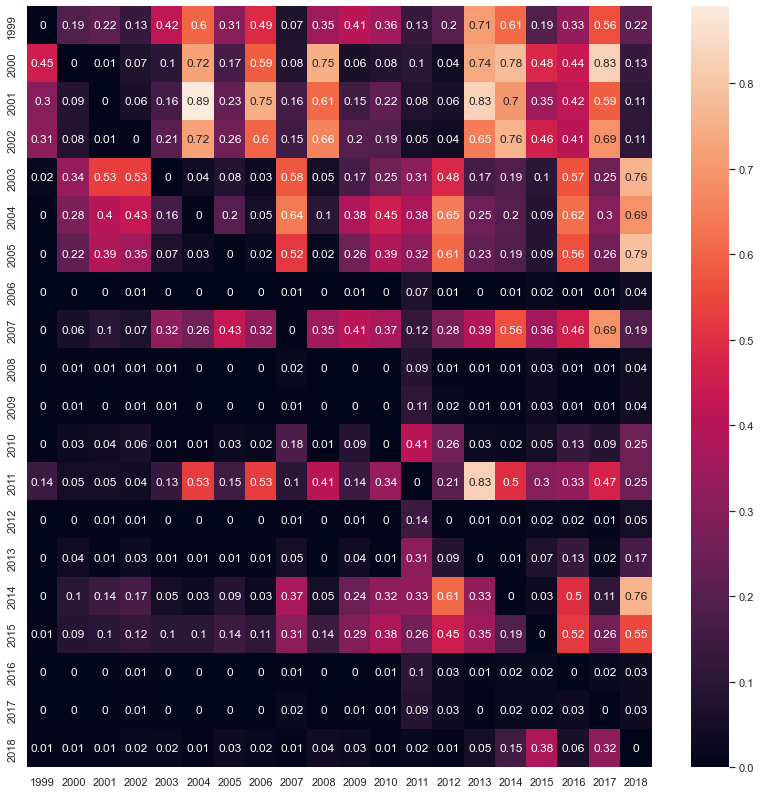

In [489]:
import seaborn as sns
plt.figure(figsize=(14,14))
ax=sns.heatmap(matrix_intersection_communities.astype(float),annot=True)

In [761]:
nodes.sort_values(by='eigenvector_centrality_orgorg3_single2018')[:100]

node     index  \
27595                                         Baliopharm  255424.0   
32803                                         iMedicWare  302621.0   
24039                            Tianheng Pharmaceutical  400421.0   
32822                                 Tonghan Biological  302899.0   
32823                          Jiashi Shang Yang Medical  302900.0   
24014                             WellStar Health System  230684.0   
6537                                               Nuvon   58753.0   
32844                                             Duxact  472300.0   
32847                                            Web100T  303152.0   
24006                                 Arc Medical Design  230656.0   
19104                                             Evolus   96421.0   
32874  Cardinal Spine - PALO ALTO Cervical Static Cor...  322875.0   
15961                           Laboratory Sales Limited   79271.0   
23978                Tarpon BioSystems - BioSMB Platform  643742.0   
32795                                          Injurymap  302430.0   
19111                                     Gene Solutions   86864.0   
32899                           New Beginnings Minnesota  303903.0   
32922                                 Northern Vine Labs  304183.0   
23951                                          Dr Foster  230300.0   
32925                              Alberta Green Biotech  304287.0   
6208                                                Huli  407720.0   
32929                                                WIM  304886.0   
15921                                  The Scooter Store  545130.0   
15919                                     Nutech Medical   52624.0   
23928                        Wheat Ridge Animal Hospital  230137.0   
23927         Veterinary Specialty Hospital of San Diego  230136.0   
32977                                RockGarden Cannabis  305388.0   
32988                                  Englewood Eyecare  305403.0   
23913                                               COGY  544720.0   
32897                                            YogaOne  303879.0   
32998                                  Orit Laboratories  306712.0   
32787                                     The Dental Hub  302363.0   
32779  MedHelp International - Online Community Business  302279.0   
16064                                   Peak Wheelchairs   60613.0   
6639                                     Cardiopulmonary   17525.0   
10080                                                HBA  338774.0   
32661            University Hospital of South Manchester  480976.0   
32662  Central Manchester University Hospitals NHS Fo...  352699.0   
24183                              Toe River Home Health  232117.0   
24181                          Medical Imaging Resources  232073.0   
32685  AxisPoint Health - Health Platform Business (A...  301031.0   
32688                                     UTH Healthcare  301079.0   
19044                 Willamette Valley Treatment Center   86120.0   
24144                       Access Integrated Healthcare  231751.0   
24141                                            it-mark  231718.0   
24129                  Suzhou Han's Chemical Engineering  231619.0   
10131                                    VANGUARD-Gruppe  548842.0   
24125                                    Sunset Mobility  231579.0   
32704                         Pain Specialists of Austin  301240.0   
32705                         Central Texas Pain Centers  301241.0   
24123                                            Ciscura  231576.0   
24116                                   Optim Healthcare  231539.0   
32723                             St. Elizabeth Hospital  301500.0   
24106                       Accountable Health Solutions  231464.0   
24097                            Legacy Physical Therapy  231460.0   
24093                              Lamda Pharmaceuticals  231405.0   
24084                                             Yixing  5399

In [496]:
year=2005
string='orgorg3_single_/orgorg3_single'+str(year)+'.gpickle'
network=nx.readwrite.read_gpickle(string)

In [719]:
def get_matrix(benchmark=False):
    labels=list(nodes.industry.unique())
    #labels=continents[:4]+continents[5:]
    labels_matrix=pd.DataFrame(columns=labels,index=names_matrix)
    for number in tqdm(range(20)):
        year=1999+number
        string='orgorg3_single_/orgorg3_single'+str(year)+'.gpickle'
        network=nx.readwrite.read_gpickle(string)
        if benchmark:
            subset=nodes.iloc[list(network.nodes)]
            #print(subset)
        else:
            subset=nodes.iloc[lista_community[number].communities[2]]
            #print(subset)
        percentages=subset.industry.value_counts()/len(subset)
        for label in labels:
            try:
                labels_matrix.loc[str(year),label]=percentages[label]
            except KeyError:
                labels_matrix.loc[str(year),label]=0
    return labels_matrix
#matrix1=get_matrix(benchmark=True)
matrix4=get_matrix(benchmark=False)


  0%|          | 0/20 [00:00<?, ?it/s]

In [720]:
matrix3=round(matrix3.astype(float),2)
matrix4=round(matrix4.astype(float),2)

In [721]:
matrix3=matrix3.loc[:, (matrix3 != 0).any(axis=0)]
matrix4=matrix4.loc[:, (matrix4 != 0).any(axis=0)]

In [717]:
matrix1==matrix4

ValueError: Can only compare identically-labeled DataFrame objects

In [ ]:
matrix1=get_matrix(benchmark=True)
matrix2=get_matrix(benchmark=False)

In [687]:
labels=list(nodes.industry.unique())
matrix3=pd.DataFrame(columns=labels,index=names_matrix)
for i in range(len(matrix3)):
    for j in range(len(matrix3.columns)):
        try:
            matrix3.iloc[i,j]=(matrix2.iloc[i,j]-matrix1.iloc[i,j])/matrix1.iloc[i,j]
        except:
            matrix3.iloc[i,j]=0
matrix3=matrix3.loc[:, (matrix3 != 0).any(axis=0)]          

<ipython-input-687-9cdb73bbf172>:6: RuntimeWarning: invalid value encountered in double_scalars
  matrix3.iloc[i,j]=(matrix2.iloc[i,j]-matrix1.iloc[i,j])/matrix1.iloc[i,j]
<ipython-input-687-9cdb73bbf172>:6: RuntimeWarning: divide by zero encountered in double_scalars
  matrix3.iloc[i,j]=(matrix2.iloc[i,j]-matrix1.iloc[i,j])/matrix1.iloc[i,j]


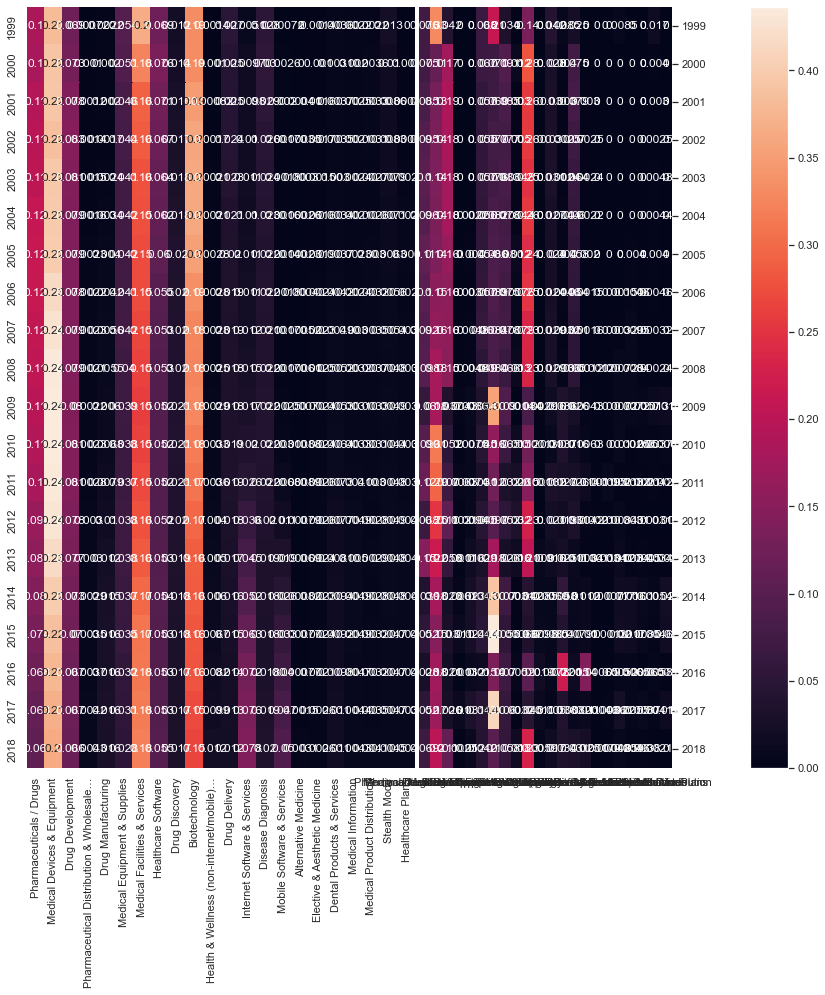

In [639]:
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,14))
fig.subplots_adjust(wspace=0.01)
sns.heatmap(matrix1.astype(float), ax=ax1,annot=True, cbar=False)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(matrix2.astype(float), ax=ax2,annot=True, cbar=False)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
plt.show()

In [724]:
matrix2

Pharmaceuticals / Drugs  Medical Devices & Equipment  Drug Development  \
1999                     0.15                         0.24              0.06   
2000                     0.16                         0.23              0.05   
2001                     0.08                         0.23              0.06   
2002                     0.17                         0.20              0.06   
2003                     0.08                         0.25              0.06   
2004                     0.15                         0.30              0.05   
2005                     0.12                         0.30              0.06   
2006                     0.11                         0.28              0.06   
2007                     0.08                         0.37              0.05   
2008                     0.12                         0.29              0.06   
2009                     0.08                         0.36              0.05   
2010                     0.11                         0.32              0.06   
2011                     0.14                         0.26              0.09   
2012                     0.15                         0.27              0.10   
2013                     0.09                         0.25              0.12   
2014                     0.13                         0.20              0.12   
2015                     0.12                         0.32              0.08   
2016                     0.09                         0.28              0.09   
2017                     0.14                         0.18              0.11   
2018                     0.10                         0.26              0.09   

      Drug Manufacturing  Medical Equipment & Supplies  \
1999                0.01                          0.06   
2000                0.00                          0.03   
2001                0.00                          0.05   
2002                0.00                          0.02   
2003                0.00                          0.04   
2004                0.00                          0.02   
2005                0.01                          0.03   
2006                0.00                          0.03   
2007                0.00                          0.03   
2008                0.00                          0.03   
2009                0.01                          0.02   
2010                0.01                          0.03   
2011                0.01                          0.02   
2012                0.01                          0.02   
2013                0.01                          0.03   
2014                0.01                          0.02   
2015                0.01                          0.03   
2016                0.01                          0.03   
2017                0.01                          0.02   
2018                0.01                          0.02   

      Medical Facilities & Services  Healthcare Software  Drug Discovery  \
1999                           0.09                 0.02            0.03   
2000                           0.09                 0.02            0.04   
2001                           0.25                 0.07            0.01   
2002                           0.13                 0.04            0.04   
2003                           0.24                 0.08            0.01   
2004                           0.15                 0.04            0.04   
2005                           0.16                 0.05            0.02   
2006                           0.20                 0.06            0.01   
2007                           0.16                 0.04            0.01   
2008                           0.15                 0.05            0.03   
2009                           0.22                 0.05            0.01   
2010                           0.16                 0.05            0.01   
2011                           0.09                 0.03            0.04   
2012                           0.09       

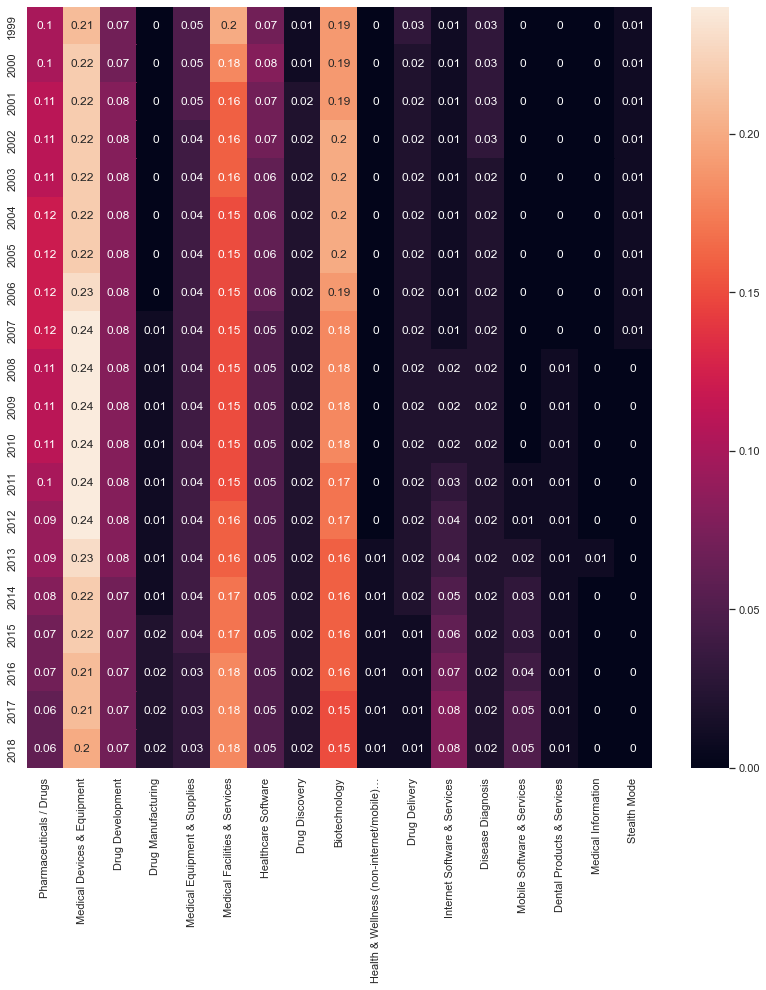

In [751]:
import seaborn as sns
plt.figure(figsize=(14,14))
ax=sns.heatmap(matrix1.astype(float),annot=True)

In [762]:
newlist

NameError: name 'newlist' is not defined

In [743]:
newlist1=[]
newlist2=[]
newlist3=[]
for i in matrix1.index:
    newlist1.append(list(matrix2.loc[i].sort_values(ascending=False).index[:5]))
    newlist2.append(list(matrix3.loc[i].sort_values(ascending=False).index[:5]))
    newlist3.append(list(matrix4.loc[i].sort_values(ascending=False).index[:5]))

In [755]:
pd.DataFrame(newlist3)

0                              1  \
0     Medical Devices & Equipment  Medical Facilities & Services   
1                   Biotechnology               Drug Development   
2                   Biotechnology               Drug Development   
3                   Biotechnology               Drug Development   
4                   Biotechnology               Drug Development   
5                   Biotechnology               Drug Development   
6                   Biotechnology               Drug Development   
7                   Biotechnology               Drug Development   
8                   Biotechnology               Drug Development   
9                   Biotechnology    Medical Devices & Equipment   
10  Medical Facilities & Services    Medical Devices & Equipment   
11    Medical Devices & Equipment  Medical Facilities & Services   
12    Medical Devices & Equipment                  Biotechnology   
13    Medical Devices & Equipment                  Biotechnology   
14    Medical Devices & Equipment                  Biotechnology   
15  Medical Facilities & Services    Medical Devices & Equipment   
16  Medical Facilities & Services    Medical Devices & Equipment   
17   Internet Software & Services    Medical Devices & Equipment   
18  Medical Facilities & Services    Medical Devices & Equipment   
19                  Biotechnology    Medical Devices & Equipment   

                                2                              3  \
0                   Biotechnology        Pharmaceuticals / Drugs   
1     Medical Devices & Equipment            Healthcare Software   
2     Medical Devices & Equipment        Pharmaceuticals / Drugs   
3     Medical Devices & Equipment        Pharmaceuticals / Drugs   
4     Medical Devices & Equipment        Pharmaceuticals / Drugs   
5     Medical Devices & Equipment        Pharmaceuticals / Drugs   
6     Medical Devices & Equipment        Pharmaceuticals / Drugs   
7     Medical Devices & Equipment        Pharmaceuticals / Drugs   
8     Medical Devices & Equipment        Pharmaceuticals / Drugs   
9                Drug Development        Pharmaceuticals / Drugs   
10            Healthcare Software                  Biotechnology   
11                  Biotechnology        Pharmaceuticals / Drugs   
12        Pharmaceuticals / Drugs  Medical Facilities & Services   
13               Drug Development  Medical Facilities & Services   
14  Medical Facilities & Services        Pharmaceuticals / Drugs   
15            Healthcare Software   Internet Software & Services   
16            Healthcare Software        Pharmaceuticals / Drugs   
17     Mobile Software & Services  Medical Facilities & Services   
18            Healthcare Software        Pharmaceuticals / Drugs   
19               Drug Development  Medical Facilities & Services   

                                4  
0    Medical Equipment & Supplies  
1         Pharmaceuticals / Drugs  
2             Healthcare Software  
3   Medical Facilities & Services  
4   Medical Facilities & Services  
5   Medical Facilities & Services  
6   Medical Facilities & Services  
7   Medical Facilities & Services  
8   Medical Facilities & Services  
9   Medical Facilities & Services  
10        Pharmaceuticals / Drugs  
11            Healthcare Software  
12               Drug Development  
13        Pharmaceuticals / Drugs  
14               Drug Development  
15   Medical Equipment & Supplies  
16   Medical Equipment & Supplies  
17                  Biotechnology  
18   Medical Equipment & Supplies  
19        Pharmaceuticals / Drugs

In [526]:
CB_companies=pd.read_csv('~/Documents/GitHub/crunch_net/notebook/CB_with_covariates_companies.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,146,147,148,149) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Adding statistics computed before

In [759]:
nodes[nodes.loc[:,'bipartite']==1]

node     index  \
0                                      Shionogi & Co.  262824.0   
1                                     Astellas Pharma  243168.0   
2                           Sumitomo Dainippon Pharma  447180.0   
3                                      Konica Minolta   57191.0   
4                               Takeda Pharmaceutical  373007.0   
...                                               ...       ...   
50457                                   Carrot Health  556442.0   
50458                                  Beijing Shouyi  669346.0   
50459                     Streamline Health Solutions  439295.0   
50460                                         Avelead  439775.0   
50461  Dermatology Associates and Skin Surgery Center  669451.0   

             country      continent                       industry  \
0              Japan           Asia        Pharmaceuticals / Drugs   
1              Japan           Asia        Pharmaceuticals / Drugs   
2              Japan           Asia        Pharmaceuticals / Drugs   
3              Japan           Asia    Medical Devices & Equipment   
4              Japan           Asia        Pharmaceuticals / Drugs   
...              ...            ...                            ...   
50457  United States  North America   Internet Software & Services   
50458          China           Asia    Medical Devices & Equipment   
50459  United States  North America            Healthcare Software   
50460  United States  North America   Internet Software & Services   
50461  United States  North America  Medical Facilities & Services   

       foundation      target_status  bipartite     id  \
0          1878.0  IPO / Went public          1      0   
1          1923.0  IPO / Went public          1      1   
2          1897.0  IPO / Went public          1      2   
3          1936.0  IPO / Went public          1      3   
4          1781.0  IPO / Went public          1      4   
...           ...                ...        ...    ...   
50457      2014.0           Acquired          1  50457   
50458      1998.0           Acquired          1  50458   
50459         NaN  IPO / Went public          1  50459   
50460      2014.0           Acquired          1  50460   
50461         NaN           Acquired          1  50461   

       voterank_orgorg3_single1999  voterank_orgorg3_single2000  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   
...                            ...                          ...   
50457                          NaN                          NaN   
50458                          NaN                          NaN   
50459                          NaN                          NaN   
50460                          NaN                          NaN   
50461                          NaN                          NaN   

       voterank_orgorg3_single2001  voterank_orgorg3_single2002  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   
...                            ...                          ...   
50457                          NaN                          NaN   
50458                          NaN                          NaN   
50459                          NaN                          NaN   
50460                          NaN                          NaN   
50461                          NaN                          NaN   

       voterank_orgorg3_single2003  voterank_orgorg3_single2004  \
0                            

In [818]:
nodes.to_csv('CB_with_EVERYTHING(COMMUNITIES).csv')